# Model showcase
Model showcase for the classification task of temperature being above a certain quantile threshold
* Chosen hybrid model: bootstrapped skill as a function of threshold/timeagg/separation
* Chosen hybrid model: reliability diagrams
* Timeserie properties, ways to deal with climate trend
* Skill of the alternative previous models

In [2]:
import sys
import os
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors

from pathlib import Path
from scipy.signal import detrend
from sklearn.metrics import brier_score_loss, log_loss
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from statsmodels.nonparametric.smoothers_lowess import lowess

#sys.path.append(os.path.expanduser('~/Documents/Weave'))
sys.path.append(os.path.expanduser('~/Weave'))
from Weave.models import fit_predict, fit_predict_evaluate, evaluate, hyperparam_evaluation, map_foldindex_to_groupedorder, BaseExceedenceModel, HybridExceedenceModel
from Weave.utils import brier_score_clim, reliability_plot

In [4]:
#basedir = Path('/nobackup_1/users/straaten/')
basedir = Path('/scistor/ivm/jsn295/')
# Latest:
skillpath = basedir / 'bootstrap_hybrid_noncv_base_noncv/fit_base_to_all_cv=True.max_depth=5.n_estimators=2500.min_samples_split=30.max_features=35.n_jobs=19.bss.parquet' # Base logistic regression fitted to the full (non-cv) dataset, as is the reference model
skillpath_base = basedir / 'bootstrap_base/BaseExceedenceModel.bs.parquet' # Only the logistic regression
# Alternatives
skillpath_hybrid = basedir / 'hybrid_old/bootstrap_hybrid_base/max_depth=5.n_estimators=2500.min_samples_split=30.max_features=35.n_jobs=19.bs.parquet' # Latest but base and reference (!) fitted to part of the data
skillpath_hybrid_strict = basedir / 'hybrid_old/bootstrap_hybrid_base_noncv/max_depth=5.n_estimators=2500.min_samples_split=30.max_features=35.n_jobs=19.bs.parquet' # Latest but base fitted to part of the data and reference to full
skillpath_bs = basedir / 'hybrid_old/bootstrap_hybrid/max_depth=5.n_estimators=2500.min_samples_split=30.max_features=35.n_jobs=19.bs.parquet' # Relative to fixed climatology (inflated due to trend)
skillpath_parcor = basedir / 'non_hybrid/bootstrap_full/max_depth=7.n_estimators=1500.min_samples_split=40.max_features=35.n_jobs=7.bs.parquet' # Old linear detrended classifier skill, with partial correlation patterns as input
skillpath_normcor = basedir / 'non_hybrid/bootstrap_normcor/max_depth=5.n_estimators=2500.min_samples_split=30.max_features=35.n_jobs=19.bs.parquet' # Old linear detrended classifier skill, with normal correlation patterns as input

inputpath = basedir / 'clusters_cv_spearmanpar_varalpha_strict' # Latest dimreduced X and y data 

## Bootstrapped skill

In [5]:
def transform_to_skill(dataframe):
    """
    Handles two occasions to add BSS columns to the frame. 
    Either a fixed climatology was appended
    Or another type of reference was used within bootstrapping (and 'bs' was already 'bss')
    """
    for quantile in ['0.05','0.5','0.95']:
        if 'clim' in dataframe.columns:
            dataframe[f'{quantile}_skill'] = 1 - dataframe[quantile] / dataframe['clim']
        else:
            dataframe[f'{quantile}_skill'] = dataframe[float(quantile)] # Float indexed (not mixed with the str of 'clim')
    return dataframe

def skill_plot(df, respaggs: list = None, thresholds: list = None, blocksizes: list = None, ylabel: str = 'brier skill score'):
    """
    Plots the bootstrapped BSS bounds (0.05 and 0.95) for different block sizes
    each panel shows the skill as a function of separation / (gapsize) 
    for a single repsonse aggregation and threshold.
    """
    if respaggs is None:
        respaggs = df.index.get_level_values('timeagg').unique().sort_values()
    if thresholds is None:
        thresholds = df.index.get_level_values('threshold').unique().sort_values()
    if blocksizes is None:
        blocksizes = df.index.get_level_values('blocksize').unique() # Can contain nan, meaning blocksize=1 and normal bootstrapping
    cmap=plt.get_cmap('Blues')
    cmaplist = [cmap(int(i)) for i in np.linspace(50, cmap.N-30, num = len(blocksizes))]
    
    fig,axes = plt.subplots(ncols = len(respaggs), nrows = len(thresholds), squeeze = False, sharey=True, sharex = True, figsize = (3*len(respaggs),2.5*len(thresholds)))
    fig.patch.set_facecolor('white')
    for i, threshold in enumerate(thresholds):
        for j, respagg in enumerate(respaggs[::-1]):
            ax = axes[i,j]
            ax.set_prop_cycle(color = cmaplist)
            for blocksize in blocksizes[::-1]:
                selection = df.loc[(respagg,slice(None),threshold,blocksize),['0.05_skill','0.95_skill']]
                ax.fill_between(x = selection.index.get_level_values('separation'), y1 = selection['0.05_skill'], y2 = selection['0.95_skill'], label = str(int(blocksize)) if not np.isnan(blocksize) else '1')
            ax.hlines(y = 0, xmin = df.index.get_level_values('separation').min(), xmax = df.index.get_level_values('separation').max(),label = 'clim', color = 'crimson')
            ax.set_title(f'threshold {threshold}, respagg {respagg}')
            if j == 0:
                ax.set_ylabel(ylabel)
            if i == len(thresholds) - 1:
                ax.set_xlabel('separation [days]')
            
    axes[-1,0].legend(title = 'blocksize', loc = 'upper left')
    return fig, axes

### Brier score

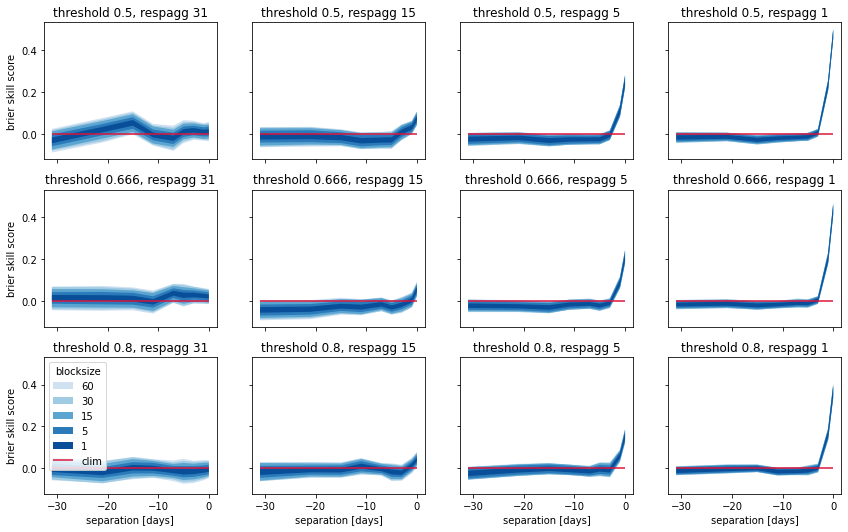

In [6]:
frame = pd.read_parquet(skillpath)
frame = transform_to_skill(frame)
fig, axes = skill_plot(frame, respaggs = [1,5,15,31], thresholds = [0.5,0.666,0.8])
plt.tight_layout()
plt.show()

General trends here are:
* More uncertainty in the score for larger response aggregations and more extremes (0.9 not even shown) increasing blocksize to the maximum has most effect for the largest aggregation (less independent data).
* Curvature becomes steeper for smaller reponse aggregations. But the sudden entering into 'skillful' area is less present for the extremes. The absence of curving for the largest aggregations has nothing to do with the quality of precursor information. It is the same. Conceptually it could be that there is less of a relation (teleconnection or feedback) to be used. These could take to long, and persistence cannot make up for it?
* At large separations the small response aggregations are just quite unpredictable. Meaning that predicting the 31 day stuff is not because of succesful prediction of the first 15 days, or 7 or less days.

We can compare this latest model (that is relative to the trend model with time-dependent probability) to an older non-hybrid version that dealt with the classification problem in detrended space. It is therefore relative to the a fixed climatological probability. Uncertainty is certainly larger. Shapes are comparable. Which is contrary to what I first thought. I believed that the additive approach made it all steeper.

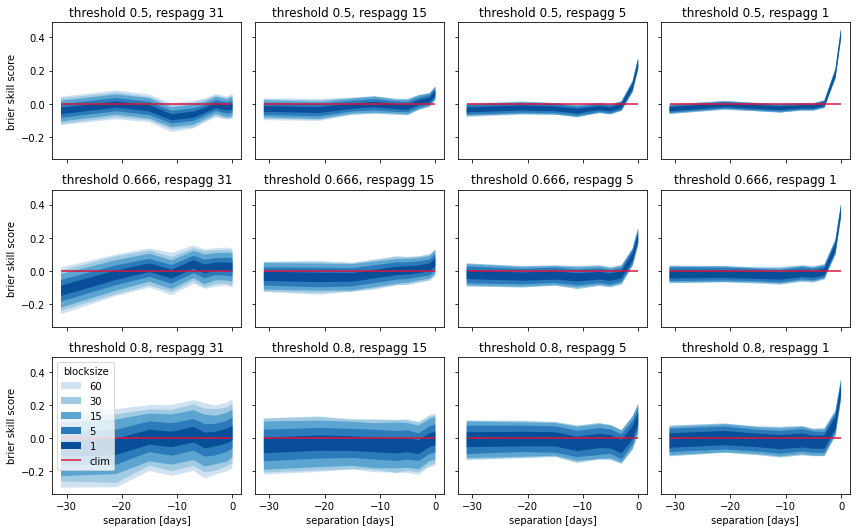

In [50]:
frame = pd.read_parquet(skillpath_parcor)
frame = transform_to_skill(frame)
fig, axes = skill_plot(frame, respaggs = [1,5,15,31], thresholds = [0.5,0.666,0.8])
plt.tight_layout()
plt.show()

### Potential economic value
Score based on contigency table (binarization of predictions). Maximum score obtainable as potential economic value (Richardson, 2000) for probabilistic forecasts occurs for the c/l ratio that is equal to climatological frequency of positive (user might be fictional). If forecasts are reliable this maximum is found when p_tresh is used equal to the clim_freq. The whole then reduces to the kuipers score = hit_rate - false_alarm_rate

Here we set the frequency, and thus c/l ratio and thus prob-threshold, equal to 1 - quantile threshold.

In [31]:
ks_path = basedir / 'bootstrap_hybrid_noncv/fit_base_to_all_cv=True.max_depth=5.n_estimators=2500.min_samples_split=30.max_features=35.n_jobs=14.ks.parquet'
kss_path = basedir / 'bootstrap_hybrid_noncv_base_noncv/fit_base_to_all_cv=True.max_depth=5.n_estimators=2500.min_samples_split=30.max_features=35.n_jobs=14.kss.parquet' # Normalized
ks_base = basedir / 'bootstrap_base_noncv/fit_base_to_all_cv=True.max_depth=5.n_estimators=2500.min_samples_split=30.max_features=35.n_jobs=14.ks.parquet'

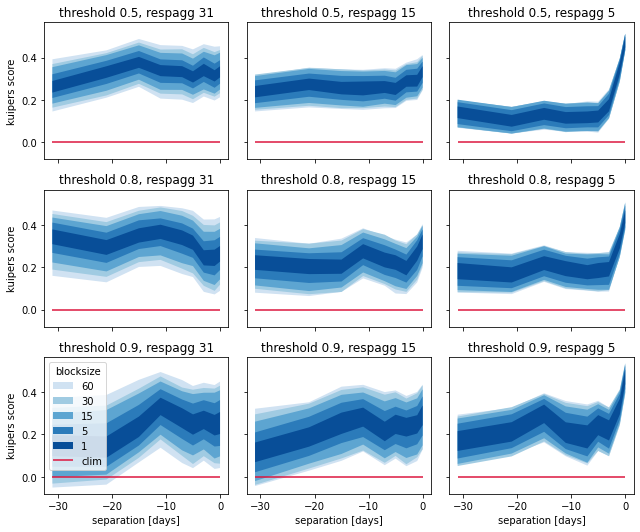

In [32]:
frame = pd.read_parquet(ks_path)
frame = transform_to_skill(frame)
fig, axes = skill_plot(frame, respaggs = [5,15,31], thresholds = [0.5,0.8,0.9], ylabel = 'kuipers score')
plt.tight_layout()
plt.show()

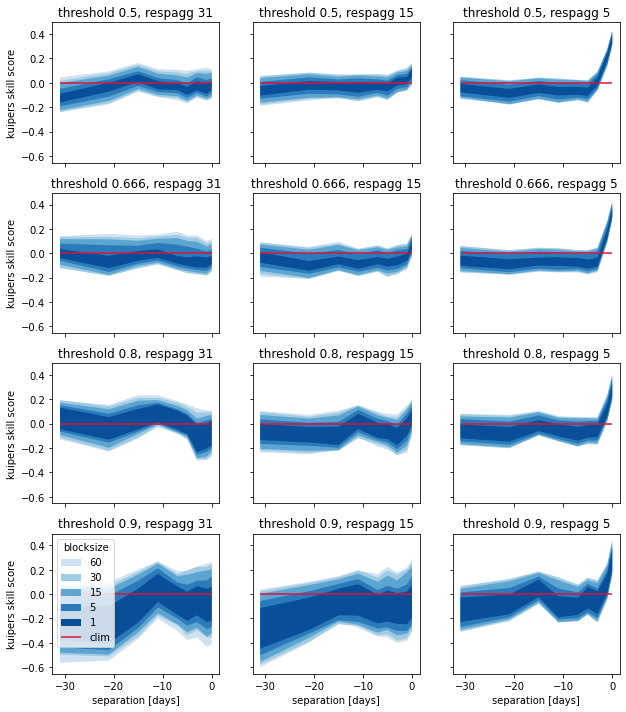

In [34]:
frame = pd.read_parquet(kss_path)
frame = transform_to_skill(frame)
fig, axes = skill_plot(frame, respaggs = [5,15,31], thresholds = [0.5,0.666,0.8,0.9], ylabel = 'kuipers skill score')
plt.tight_layout()
plt.show()

* What seems interesting here is the non-flatness of the curves. For a given threshold the 'peaking lead time'  shifts backwards (ignoring final increase for the short response), from -11 when predicting 31 day values to -15 when predicting 5 day values. This shifting could be a hint of a window of predictability, namely a preferred timescale between input and response, so that when your response is less far into the future you'd have to look further back for the most useful information / teleconnection
* Because of the binarization with a single probability threshold and the trend in the data, the Kuipers score is only sensitive to a very small part of the data. Because we nicely let our full hybrid model have a trend in it (from which it creates relatively modest probabilistic deviations), both the hybrid and the base will always be above / below the threshold for large stretches of time. This makes the the PEV as a skill score only sensitive to model differences in a small part of the dataset, namely that part where real probability hovers around the fixed one, so where deviations count

### AUC
Could be more descriminative than Kuipers score because of the use of multiple thresholds.

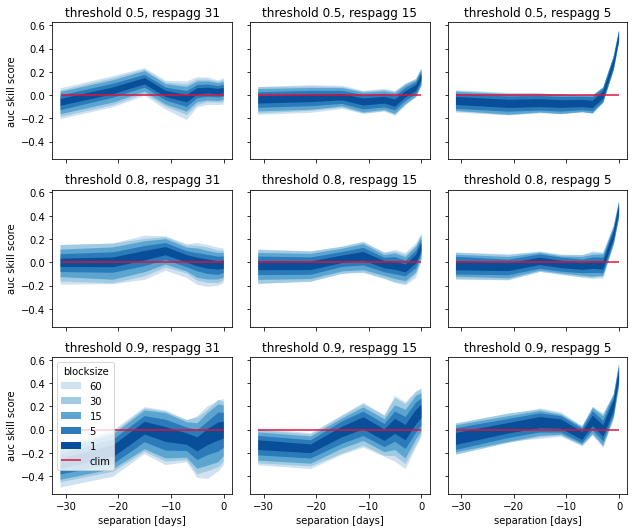

In [17]:
aucss_path = basedir / 'bootstrap_aucss_hybrid_noncv_base_noncv/fit_base_to_all_cv=True.max_depth=5.n_estimators=2500.min_samples_split=30.max_features=35.n_jobs=10.bs.parquet' # Normalized 
frame = pd.read_parquet(aucss_path)
frame = transform_to_skill(frame)
fig, axes = skill_plot(frame, respaggs = [5,15,31], thresholds = [0.5,0.8,0.9], ylabel = 'auc skill score')
plt.tight_layout()
plt.show()

Shows a different dependence on extremity than brier skill score. Especially for the respagg of 5.

## Reliability of the chosen approach
The BSS paint a discouraging picture for empirical long-lead predictability of Northwest-Europe summer temperature. Reliability diagrams are more promising. Investigate the finding that not all improvement upon the base trend model is shown by BSS. Also to compare thresholds and response aggregations among each other. Hypotheses:
* More resolution with decreasing separation as you get closer to the event
* Predictability of large timescale not within the first few days
* Extremes are hard, but also bulk of the distribution has low signal/noise. Intermediate thresholds are most predictable

Conclusions:
* Seems true for the response timescales with most 'curve', but in a non-linear fashion. Not true for the large respaggs.
* Seems to be the case.
* Unconclusive

In [35]:
def read_data(responseagg = 3, separation = -7, trended = False, quantile = 0.8):
    """
    Returns the selcted X and y data
    A dataframe and a (de)trended Series
    """
    if trended:
        Y_path = inputpath / 'response.multiagg.trended.parquet'
    else:
        Y_path = inputpath / 'response.multiagg.detrended.parquet'
    X_path = inputpath / 'precursor.multiagg.parquet'
    y = pd.read_parquet(Y_path).loc[:,(slice(None),responseagg,slice(None))].iloc[:,0] # Only summer
    X = pd.read_parquet(X_path).loc[y.index,(slice(None),slice(None),slice(None),slice(None),separation,slice(None),slice(None))].dropna(axis = 0, how = 'any') # both metrics
    y = y.reindex(X.index)
    if not quantile is None:
        y = y > y.quantile(quantile)
    map_foldindex_to_groupedorder(X = X, n_folds = 5)
    return X, y

def get_predictions(model, respaggs: list, thresholds: list, separations: list, trended: bool = True):
    """
    For the requested models (unique combinations of respagg, threshold, separation)
    It gets the 5-fold cv fit and predict (some randomness involved here)
    Returns a dataframe of the made predictions, and the response.
    If multiple thresholds or respaggs are requested it needs to also
    return different versions of y. Therefore these are also stored and returned
    """
    results = []
    ys = []
    for respagg, separation, threshold in itertools.product(respaggs, separations, thresholds):
        X, y = read_data(respagg, separation, trended = trended, quantile = threshold)
        preds = fit_predict(model, X, y, n_folds = 5, split_on_year = True)
        preds = preds.to_frame()
        preds.columns = pd.MultiIndex.from_tuples([(respagg,separation,threshold)],names = ['respagg','separation','threshold'])
        results.append(preds)
        y = y.to_frame()
        y.columns = pd.MultiIndex.from_tuples([(respagg,threshold)], names = ['respagg','threshold'])
        ys.append(y)
    results = pd.concat(results, axis = 1).sort_index(axis = 1)
    ys = pd.concat(ys, axis = 1).sort_index(axis = 1)
    ys = ys.loc[:,~ys.columns.duplicated()] # removing duplicates and if only one is left return as series (preferred for the reliability plot)
    if len(ys.columns) == 1:
        ys = ys.iloc[:,0] # collapses to series
    return ys, results
    
def strip_for_reliability(frame):
    """
    Reliability plots are clearest when only one aspect (respagg, separation, threshold) changes
    This strips the non-changing aspects and returns those for the plot title.
    """
    frame = frame.copy()
    cols = pd.DataFrame({'values':[frame.columns.get_level_values(key).unique().values for key in frame.columns.names]}, index = frame.columns.names)
    cols['length'] = cols['values'].map(lambda vals: len(vals))
    cols['repr'] = cols['values'].map(lambda vals: float(vals) if len(vals) == 1 else '...')
    n_non_unique = sum(cols['length'] > 1)
    assert n_non_unique <= 1, f'Only one level of {frame.columns.names} can be non-unique'
    frame.index = frame.index.droplevel('fold')
    if n_non_unique > 0:
        frame.columns = frame.columns.droplevel(cols.loc[cols['length'] == 1].index.tolist())
    return frame, f'{cols.loc["respagg","repr"]}day > q{cols.loc["threshold","repr"]}, at {cols.loc["separation","repr"]}'

In [36]:
model = HybridExceedenceModel(fit_base_to_all_cv = True, base_only = False, n_jobs = 8, max_depth = 5, min_samples_split = 30, n_estimators = 2500, max_features = 35)
basemodel = HybridExceedenceModel(fit_base_to_all_cv = True, base_only = True)

### First hypothesis

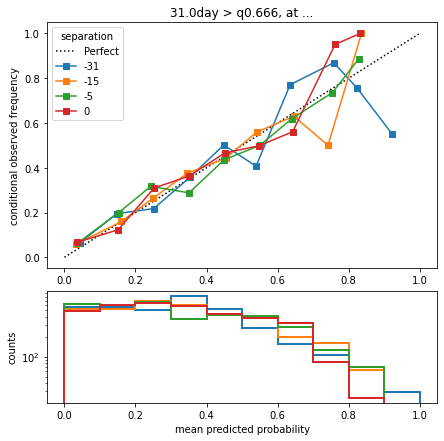

In [8]:
y_true, y_probs = get_predictions(model, respaggs = [31],thresholds = [0.666], separations = [-31,-15,-5,0])
fr, tit = strip_for_reliability(y_probs)
fig, axes = reliability_plot(y_true=y_true, y_probs = fr)
axes[0].set_title(tit)
plt.show()

There's not that much of a resolution difference the close you get to the event for large response aggregations. It does seem to get a bit more reliable though. How does this compare to the base model? Which is not dependent on separation.

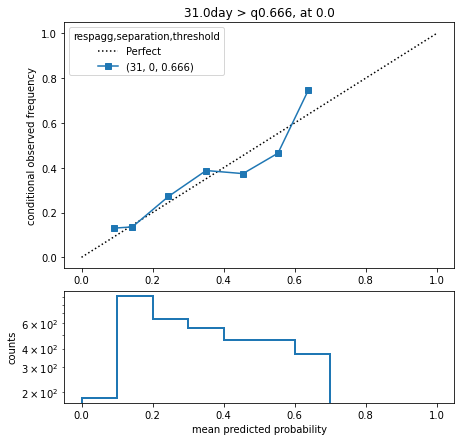

In [18]:
y_true, y_probs = get_predictions(basemodel, respaggs = [31],thresholds = [0.666], separations = [0])
fr, tit = strip_for_reliability(y_probs)
fig, axes = reliability_plot(y_true=y_true, y_probs = fr)
axes[0].set_title(tit)
plt.show()

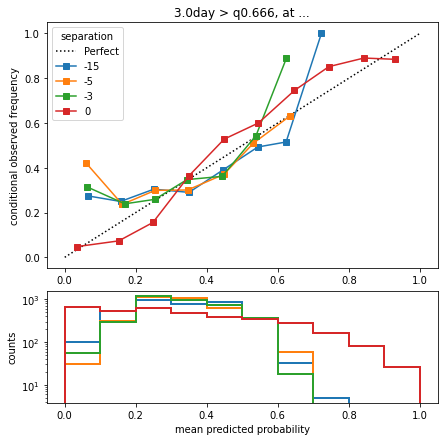

In [19]:
y_true, y_probs = get_predictions(model, respaggs = [3],thresholds = [0.666], separations = [-15,-5,-3,0])
fr, tit = strip_for_reliability(y_probs)
fig, axes = reliability_plot(y_true=y_true, y_probs = fr)
axes[0].set_title(tit)
plt.show()

The increase of resolution for a short response aggregation does not seem to behave linearly. With respagg = 3 you indeed see the biggest resolution at separation 0. 15 is not good but better (in terms of underforecasting no chance of the event) than the intermediate separations. 

### Second hypothesis

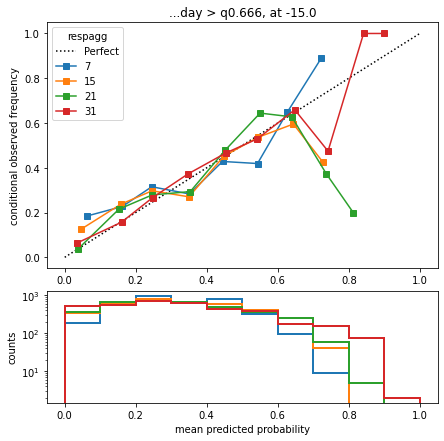

In [20]:
y_true, y_probs = get_predictions(model, respaggs = [31,21,15,7], thresholds = [0.666], separations = [-15])
fr, tit = strip_for_reliability(y_probs)
fig, axes = reliability_plot(y_true=y_true, y_probs = fr)
axes[0].set_title(tit)
plt.show()

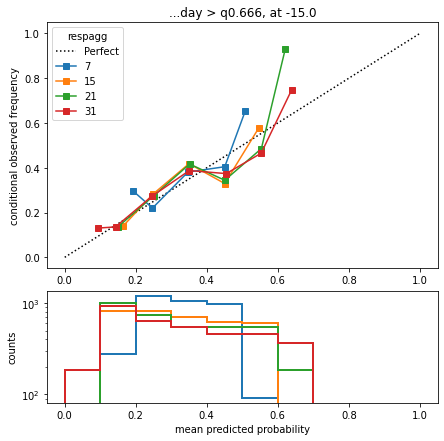

In [21]:
y_true, y_probs = get_predictions(basemodel, respaggs = [31,21,15,7], thresholds = [0.666], separations = [-15])
fr, tit = strip_for_reliability(y_probs)
fig, axes = reliability_plot(y_true=y_true, y_probs = fr)
axes[0].set_title(tit)
plt.show()

Here one really needs to view both the base model and the hybrid at the same time. Base has some resolution for all, with increasing resolution (i.e. presence of a climate trend signal) for the larger response aggregations. What you then see is that the hybrid add resolution on top of that for all... But that it has the easiest task in reliabily extending downward and upward (in probability terms) for the 31 aggregation. This source of this predictable relation thus does not lie at the shorter timescales (as all are given same input, belonging to this separation)

### Third hypothesis

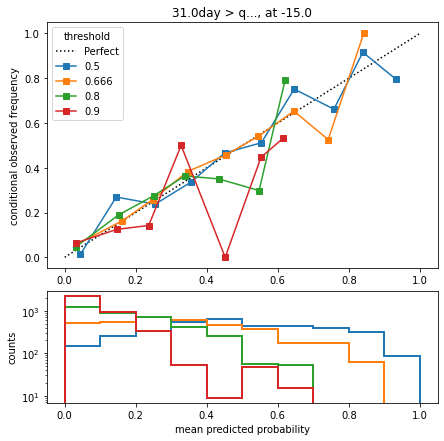

In [22]:
y_true, y_probs = get_predictions(model, respaggs = [31], thresholds = [0.5,0.666,0.8,0.9], separations = [-15])
fr, tit = strip_for_reliability(y_probs)
fig, axes = reliability_plot(y_true=y_true, y_probs = fr)
axes[0].set_title(tit)
plt.show()

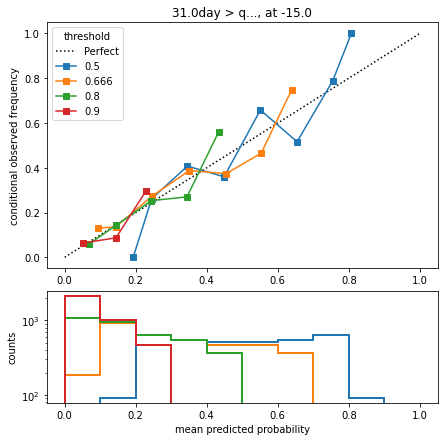

In [23]:
y_true, y_probs = get_predictions(basemodel, respaggs = [31], thresholds = [0.5,0.666,0.8,0.9], separations = [-15])
fr, tit = strip_for_reliability(y_probs)
fig, axes = reliability_plot(y_true=y_true, y_probs = fr)
axes[0].set_title(tit)
plt.show()

We cannot really reach a conclusion here. From the basemodels it is apparent that for all quantiles there is some trend to be exploited. Relative to that the model at 0.5 and 0.666 seem reliable resolution extenders. Which is somewhat visible in the bootstrapped BSS plots (normalized just lower for the extremes). And you would conclude that the more extreme the harder (no optimum). But then the probability jump made by the model on top of the trend is largest for the largest threshold. This has been trained on something so even though unreliably learned, a potential seems to exist. This is a more certain forecasting situation (0 days in between):

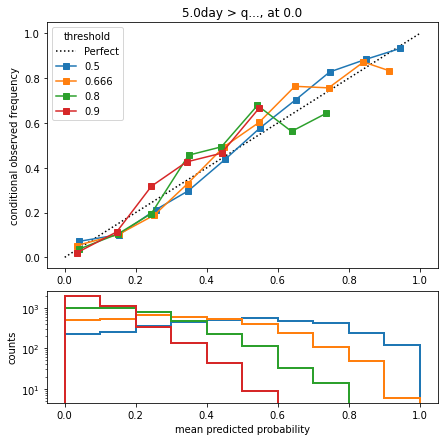

In [25]:
y_true, y_probs = get_predictions(model, respaggs = [5], thresholds = [0.5,0.666,0.8,0.9], separations = [0])
fr, tit = strip_for_reliability(y_probs)
fig, axes = reliability_plot(y_true=y_true, y_probs = fr)
axes[0].set_title(tit)
plt.show()

### Intermediate plotting example
Needed to show addition and subtraction

In [37]:
y_true, y_probs = get_predictions(model, respaggs = [31], thresholds = [0.666], separations = [-15])
y_true, y_base = get_predictions(basemodel, respaggs = [31],thresholds = [0.666], separations = [0])

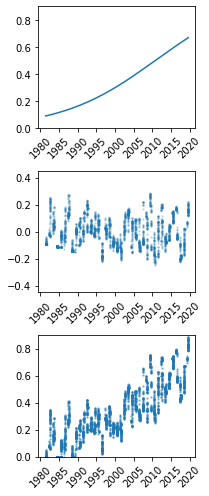

In [72]:
fig, axes = plt.subplots(nrows = 3, figsize = (3,7))
axes[0].plot(y_base.index.get_level_values('time'),y_base.values)
axes[0].set_ylim(0,0.9)
axes[0].tick_params(axis='x', labelrotation=45)
axes[1].scatter(y_base.index.get_level_values('time'),y_probs.values - y_base.values, s = 2, alpha = 0.2)
axes[1].set_ylim(-0.45,0.45)
axes[1].tick_params(axis='x', labelrotation=45)
axes[2].scatter(y_base.index.get_level_values('time'),y_probs.values, s = 2, alpha = .4)
axes[2].set_ylim(0,0.9)
axes[2].tick_params(axis='x', labelrotation=45)
plt.tight_layout()
plt.show()

## Response trends and previous alternative models
The old approach was to linearly detrend the temperature anomaly timeseries. On that detrended timeseries the quantile threshold was computed.

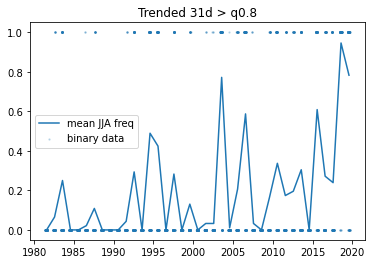

In [11]:
X, y = read_data(responseagg = 31, trended = True, quantile = 0.8)
mean_freq = y.groupby(y.index.year).mean()
mean_freq.index = pd.date_range('1981',periods = len(mean_freq), freq = 'A-JUL' )
fig, ax = plt.subplots()
ax.scatter(x = y.index, y = y, s = 2, alpha = 0.2, label = 'binary data')
ax.plot(mean_freq, label = 'mean JJA freq')
ax.legend(loc = 'center left')
ax.set_title('Trended 31d > q0.8')
plt.show()

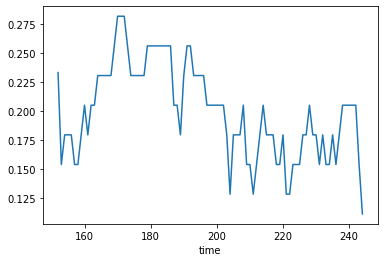

In [15]:
y.groupby(y.index.dayofyear).mean().plot()
plt.show()

Some dependence of the frequency on the season. More exceedence counts in june, does not mean that it is hotter there, just that the temp anomalies (on which threshold is set) is bigger. Part of this is also an artefact of left-stamping. (end of august value for 31 day response value actually denotes a september heatwave).

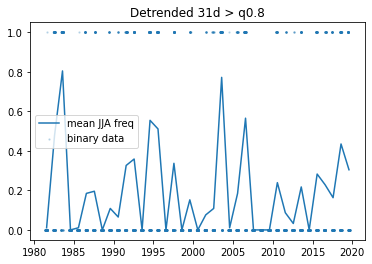

In [9]:
X, y = read_data(responseagg = 31, trended = False, quantile = 0.8)
mean_freq = y.groupby(y.index.year).mean()
mean_freq.index = pd.date_range('1981',periods = len(mean_freq), freq = 'A-JUL' )
fig, ax = plt.subplots()
ax.scatter(x = y.index, y = y, s = 2, alpha = 0.2, label = 'binary data')
ax.plot(mean_freq, label = 'mean JJA freq')
ax.legend(loc = 'center left')
ax.set_title('Detrended 31d > q0.8')
plt.show()

Different distribution of the positive class over time. Looking at the trended data you see that absolute events were rare further back. Something exceptional might have happened that is different from the more common mechanisms now. It therefore is weird to get an overrepresentation of those past events in the mixture of the positive class that is supposed to be homogeneous.
Actually the trend is most striking / problematic for the largest respaggs as was shown by the resolution of the base models. We see performance differences. Most disconcerning for me was that 2003 and 2018 are 'missed' in detrended classification.

In [29]:
model = HybridExceedenceModel(fit_base_to_all_cv = True, base_only = False, n_jobs = 8, max_depth = 5, min_samples_split = 30, n_estimators = 2500, max_features = 35)
model_for_detrended = RandomForestClassifier(n_estimators=2500, n_jobs=7, min_samples_split=30, max_depth=5, max_features = 35)
y_true, y_probs = get_predictions(model, respaggs = [31],thresholds = [0.666], separations = [-31])
y_true_det, y_probs_det = get_predictions(model_for_detrended, respaggs = [31],thresholds = [0.666], separations = [-31], trended = False)

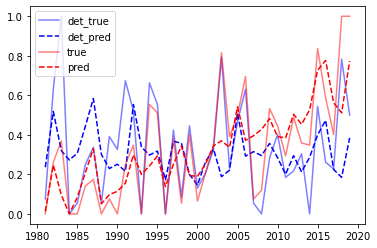

In [39]:
fig, ax = plt.subplots()
ax.plot(y_true_det.groupby(y_true_det.index.year).mean(), color = 'blue', label = 'det_true', alpha = 0.5)
ax.plot(y_probs_det.groupby(y_true_det.index.year).mean(), color = 'blue', linestyle = 'dashed', label = 'det_pred')
ax.plot(y_true.groupby(y_true.index.year).mean(), color = 'red', label = 'true', alpha = 0.5)
ax.plot(y_probs.groupby(y_true.index.year).mean(), color = 'red', linestyle = 'dashed', label = 'pred')
ax.legend(loc = 'upper left')
plt.show()

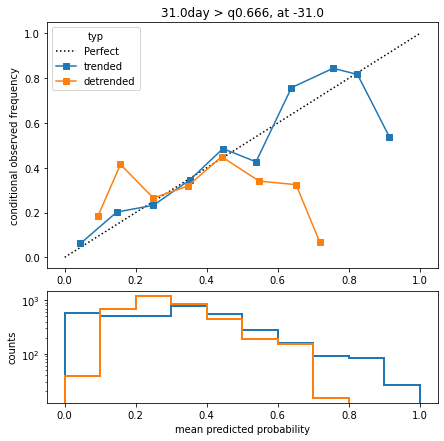

In [48]:
preds = pd.concat([y_probs, y_probs_det], axis = 1, keys = pd.Index(['trended','detrended'],name = 'typ'))
obs = pd.concat([y_true, y_true_det], axis = 1, keys = pd.Index(['trended','detrended'],name = 'typ'))
fr, tit = strip_for_reliability(preds)
fig, axes = reliability_plot(y_true=obs, y_probs = fr)
axes[0].set_title(tit)
plt.show()

Non-linear detrending does not really give a different distribution of classes over time. Even less representation of 2015+

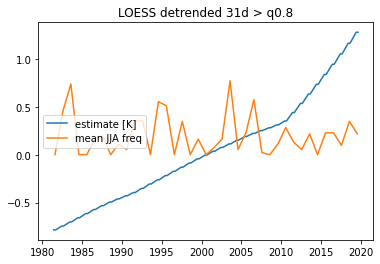

In [26]:
X, y = read_data(responseagg = 31, trended = True, quantile = None)
estimate = lowess(y,y.index.year, it = 10, frac = 0.5)
fig, ax = plt.subplots()
ax.plot(y.index, estimate[:,1], label = 'estimate [K]')
y_det = y - estimate[:,1]
y_det = y_det > y_det.quantile(0.8)
mean_freq = y_det.groupby(y_det.index.year).mean()
mean_freq.index = pd.date_range('1981',periods = len(mean_freq), freq = 'A-JUL' )
ax.plot(mean_freq, label = 'mean JJA freq')
ax.legend(loc = 'center left')
ax.set_title('LOESS detrended 31d > q0.8')
plt.show()

The other tested alternative was with quantile detrending.

In [49]:
from statsmodels.regression.quantile_regression import QuantReg
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(copy = True, with_mean = True, with_std = True)

In [50]:
X, y = read_data(responseagg = 31, trended = True, quantile = None)

In [55]:
inp = pd.DataFrame({'date':scaler.fit_transform(X.index.to_julian_date().values[:,np.newaxis]).squeeze(), 'intercept':1}, index = y.index)
qr = QuantReg(endog =y.values[:,np.newaxis], exog = inp)

In [57]:
ret = qr.fit(q = 0.8)

In [59]:
quant = inp['date'] * ret.params['date'] + inp['intercept'] * ret.params['intercept']

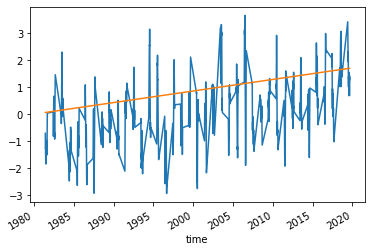

In [60]:
y.plot()
quant.plot()
plt.show()

<AxesSubplot:xlabel='time'>

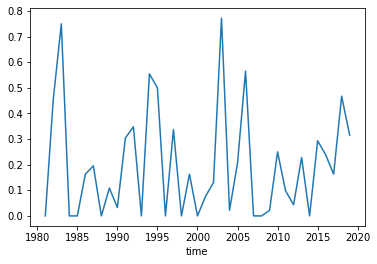

In [61]:
(y > quant).groupby(y.index.year).mean().plot()

## Hybrid target
It seems that the hybrid model is preferred, but its grounds are a bit shakey, lets take a closer look at the target for the regression random forest.

In [74]:
y_true, y_base = get_predictions(basemodel, respaggs = [31], thresholds = [0.666], separations = [-15])
residual = y_true - y_base.iloc[:,0]
residual.index = residual.index.droplevel('fold')

<AxesSubplot:xlabel='time'>

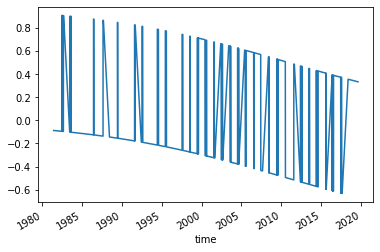

In [75]:
residual.plot()

Text(0.5, 1.0, 'What the RF regressor will train on')

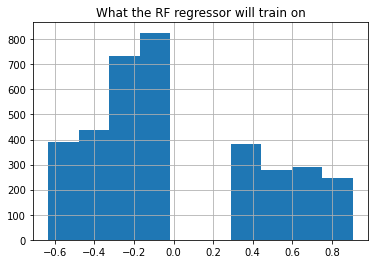

In [72]:
residual.hist()
plt.title('What the RF regressor will train on')

There is a clear distinction between negative and positive cases (below probabilistic expectation, above expextation) but that distinction becomes less between the very final underestimations like 2019 with small positive values and the very first overestimations like 1981 with small negative values. (Other response aggregations would have less of this trend in the residual).